In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
with open('/project/gpaa/machine_learning/jainam_capstone/preprocessing/LAD_labeled_batches0-16.csv', 'r') as f:
  df_labeled_init_no_liver = pd.read_csv(f)

df_labeled_init_no_liver = df_labeled_init_no_liver.rename(columns={'sample_id': "Run"})

X = df_labeled_init_no_liver.drop(['Run', 'AGE', 'white', 'black', 'hispanic', 'asian', 'male', 'female', 'binary_pathology'], axis=1)

print(df_labeled_init_no_liver.shape)

(89, 12382)


In [3]:
dict_LASSO = {}
dict_random_forest = {}
dict_rfe = {}
dict_union = {}

for filename in os.listdir('/project/gpaa/machine_learning/jainam_capstone/feature_selection/feature_selection_results_new/'):

  LASSO_list = []
  random_forest_list = []
  rfe_list = []

  if 'ranked_indices_LAD' in filename:

    s = filename.split('_')
    if 'LASSO' in filename:

      with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/feature_selection_results_new/'+filename, 'r') as f:
        df_top80 = pd.read_csv(f, header=None)
      
        top80_list = df_top80[0].values.tolist()
        top80_list = [int(i) for i in top80_list]

        for index in top80_list:
          gene = X.columns[index]
          LASSO_list.append(gene)

        s = filename.split('_')
        dict_LASSO[int(s[-1][0])] = LASSO_list

    elif 'random_forest' in filename:

        with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/feature_selection_results_new/'+filename, 'r') as f:

          df_top80 = pd.read_csv(f, header=None)
        
          top80_list = df_top80[0].values.tolist()
          top80_list = [int(i) for i in top80_list]

          for index in top80_list:
            gene = X.columns[index]
            random_forest_list.append(gene)

          s = filename.split('_')
          dict_random_forest[int(s[-1][0])] = random_forest_list

    elif 'rfe' in filename:
      with open('/project/gpaa/machine_learning/jainam_capstone/feature_selection/feature_selection_results_new/'+filename, 'r') as f:
        df_top80 = pd.read_csv(f, header=None)
      
        top80_list = df_top80[0].values.tolist()
        top80_list = [int(i) for i in top80_list]

        for index in top80_list:
          gene = X.columns[index]
          rfe_list.append(gene)

        s = filename.split('_')
        dict_rfe[int(s[-1][0])] = rfe_list

In [4]:
genes = pd.DataFrame(X.columns.tolist(), columns = ['gene_id'])

In [5]:
genes[['LASSO', 'random_forest', 'rfe']] = 0

In [6]:
for index, gene in genes['gene_id'].items():
    for split, rank_list in dict_LASSO.items():
        genes.loc[genes['gene_id'] == gene, 'LASSO'] += rank_list.index(gene)
    genes.loc[genes['gene_id'] == gene, 'LASSO'] = genes.loc[genes['gene_id'] == gene, 'LASSO'] / len(dict_LASSO) + 1
    
    for split, rank_list in dict_random_forest.items():
        genes.loc[genes['gene_id'] == gene, 'random_forest'] += rank_list.index(gene)
    genes.loc[genes['gene_id'] == gene, 'random_forest'] = genes.loc[genes['gene_id'] == gene, 'random_forest'] / len(dict_random_forest) + 1

    for split, rank_list in dict_rfe.items():
        genes.loc[genes['gene_id'] == gene, 'rfe'] += rank_list.index(gene)
    genes.loc[genes['gene_id'] == gene, 'rfe'] = genes.loc[genes['gene_id'] == gene, 'rfe'] / len(dict_rfe) + 1

In [7]:
with open('/project/gpaa/machine_learning/jainam_capstone/differential_expression/noconfound_LAD_DE_results.csv', 'r') as f:
  DE = pd.read_csv(f)

In [8]:
DE[['gene_id', 'gene_name']] = DE["Unnamed: 0"].str.split('|', expand = True)

In [9]:
DE.drop(columns="Unnamed: 0", inplace = True)

In [10]:
DE_consistency = pd.merge(DE, genes, on='gene_id', how = 'inner')

In [15]:
DE_consistency.to_csv("/project/gpaa/machine_learning/jainam_capstone/feature_selection/average_rank_LAD.csv", index = False)

In [12]:
DE_consistency

,baseMean,log2FoldChange,lfcSE,pvalue,padj,gene_id,gene_name,LASSO,random_forest,rfe
0,275.437568,0.072497,0.075454,0.282869,0.453731,ENSG00000214026,MRPL23,5622.6,5822.0,1690.8
1,425.200455,-0.098369,0.070846,0.125558,0.262492,ENSG00000144504,ANKMY1,10581.8,9783.8,6118.4
2,1644.388158,-0.461506,0.144455,0.000020,0.000638,ENSG00000102547,CAB39L,4064.6,3150.6,3130.6
3,2.016981,-0.091356,0.268938,0.225833,0.390322,ENSG00000173826,KCNH6,2341.0,2964.0,5188.0
4,2052.087496,0.111949,0.094031,0.155802,0.303235,ENSG00000103966,EHD4,1440.4,1281.0,3713.8
...,...,...,...,...,...,...,...,...,...,...
12368,3608.473573,-0.094567,0.074018,0.154895,0.301814,ENSG00000141503,MINK1,730.6,1106.6,4687.4
12369,2023.042981,0.040796,0.066566,0.504429,0.668360,ENSG00000159461,AMFR,49.8,968.2,4387.2
12370,474.734733,0.063516,0.051457,0.194113,0.353728,ENSG00000092020,PPP2R3C,1020.0,1311.8,3339.6
12371,109.683747,-0.088879,0.117523,0.316735,0.489611,ENSG00000156042,CFAP70,3817.2,3958.6,1404.8


Text(0, 0.5, 'DE_padj')

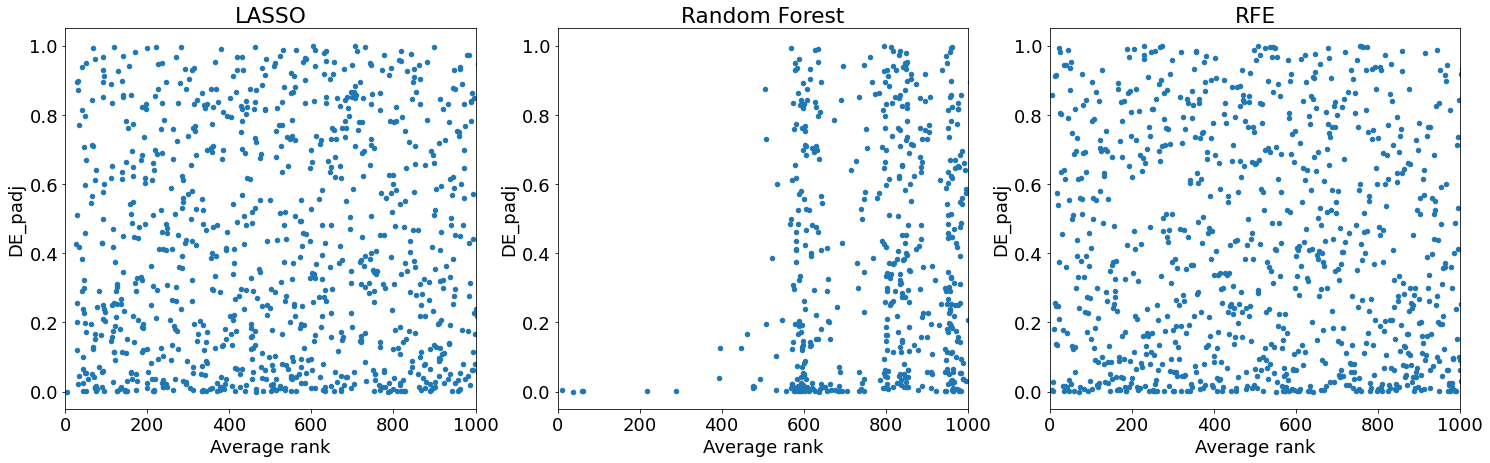

In [13]:
plt.subplots(figsize = (25, 7))
plt.rcParams.update({'font.size': 18})
plt.subplot(1,3,1)
plt.scatter(DE_consistency['LASSO'], DE_consistency['padj'], s = 20)
plt.xlim([0, 1000])
plt.title('LASSO')
plt.xlabel('Average rank')
plt.ylabel('DE_padj')
plt.subplot(1,3,2)
plt.scatter(DE_consistency['random_forest'], DE_consistency['padj'], s = 20)
plt.xlim([0, 1000])
plt.title('Random Forest')
plt.xlabel('Average rank')
plt.ylabel('DE_padj')
plt.subplot(1,3,3)
plt.scatter(DE_consistency['rfe'], DE_consistency['padj'], s = 20)
plt.xlim([0, 1000])
plt.title('RFE')
plt.xlabel('Average rank')
plt.ylabel('DE_padj')

Text(0, 0.5, 'DE_LFC')

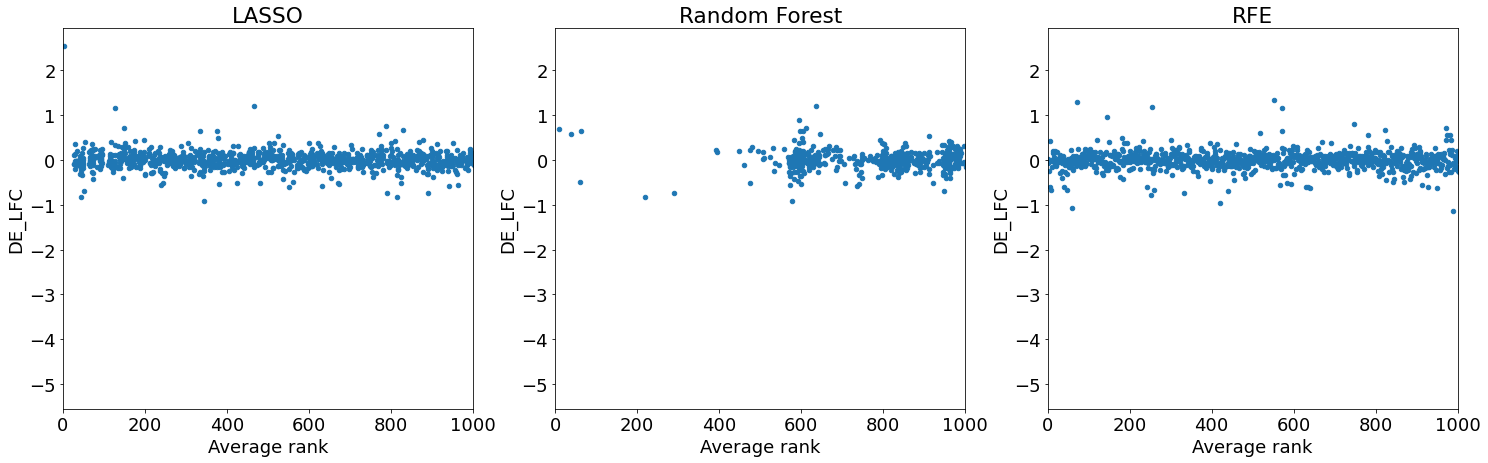

In [14]:
plt.subplots(figsize = (25, 7))
plt.rcParams.update({'font.size': 18})
plt.subplot(1,3,1)
plt.scatter(DE_consistency['LASSO'], DE_consistency['log2FoldChange'], s = 20)
plt.xlim([0, 1000])
plt.title('LASSO')
plt.xlabel('Average rank')
plt.ylabel('DE_LFC')
plt.subplot(1,3,2)
plt.scatter(DE_consistency['random_forest'], DE_consistency['log2FoldChange'], s = 20)
plt.xlim([0, 1000])
plt.title('Random Forest')
plt.xlabel('Average rank')
plt.ylabel('DE_LFC')
plt.subplot(1,3,3)
plt.scatter(DE_consistency['rfe'], DE_consistency['log2FoldChange'], s = 20)
plt.xlim([0, 1000])
plt.title('RFE')
plt.xlabel('Average rank')
plt.ylabel('DE_LFC')